<h1>Named Entity Recognition (NER) for job data 1: Data Preprocessing</h1>
<h3>Adel Rahmani</h3>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />

<div style="background-color:#FBEFFB;">
<hr style="height:5px;border:none;color:#333;background-color:#333;" />
<h3>Licence</h3>
<p>Copyright (C) 2022  Adel Rahmani

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />
</div>

<div style="background-color:#F2FBEF;">
<h2><font color=#04B404>Abstract</font></h2>
This notebook preprocesses the Adzuna job data to filter out ambiguous or malformed entries in preparation for the NER annotation pipeline.
</div>
<hr>

In [1]:
import swifter
import regex
import pandas as pd
import numpy as np

import hashlib

import spacy

import warnings
warnings.simplefilter('ignore')

from pathlib import Path
from tqdm.notebook import tqdm_notebook

----
# The Data

This pipeline uses multiple data sources to construct an annotated data set for Named Entity Recognition (NER) for job ads.

The data source comes from the [Kaggle Adzuna](https://www.kaggle.com/c/job-salary-prediction/data) data containing over 300,000 job ads, mostly from the UK.

A [lexicon of English words](https://github.com/dwyl/english-words) is used to filter the job titles before use in the pipeline. 

---
## Loading the Adzuna data

In [2]:
%%time
data = pd.read_parquet('data/Adzuna.parq')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320306 entries, 0 to 320305
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  320306 non-null  int64 
 1   Title               320306 non-null  object
 2   FullDescription     320306 non-null  object
 3   LocationRaw         320306 non-null  object
 4   LocationNormalized  320306 non-null  object
 5   ContractType        88223 non-null   object
 6   ContractTime        246321 non-null  object
 7   Company             320306 non-null  object
 8   Category            320306 non-null  object
 9   SourceName          320305 non-null  object
dtypes: int64(1), object(9)
memory usage: 24.4+ MB
CPU times: user 1.3 s, sys: 525 ms, total: 1.82 s
Wall time: 1.66 s


In [3]:
data.sample(5, random_state=0)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
135923,71469886,"VBNet Developer (SQL Server, ASPNET) Harrogate","VB.Net Developer (SQL Server, ASP.NET) Harrog...",Harrogate,Harrogate,None,permanent,Applause IT Limited,IT Jobs,jobsite.co.uk
178054,72446229,Centre Based Trainer in IT and AutoCAD,CAD Centre (UK) Ltd Centre Based Trainer in IT...,East London London South East,South East London,None,permanent,The CAD Centre Ltd,IT Jobs,totaljobs.com
188359,72635123,Sub Agent,Sub Agent required for a major Rail/Civil Engi...,"Newcastle upon Tyne, Tyne and Wear",Newcastle Upon Tyne,None,contract,VGC,Engineering Jobs,cv-library.co.uk
126675,71288596,Purchase Ledger Clerk,Hays Accountancy and Finance are currently rec...,Sheffield,Sheffield,None,None,Hays Sheffield,Accounting & Finance Jobs,MyUkJobs
211726,68680609,Managing Consultant Construction/Civils/FM,Managing Consultant Construction/Civils/FM B...,Bristol Avon South West,UK,None,permanent,Fresh Partnership,HR & Recruitment Jobs,totaljobs.com


## English lexicon to validate words 

This is a way to cull all the malformed/mispelled job titles 

In [4]:
with open('data/words_alpha.txt', 'r') as f:
    ENGLISH_LEXICON = set(f.read().splitlines())
    
len(ENGLISH_LEXICON)

370103

### Basic regexes for text cleaning

In [5]:
pattern_censored_word   = regex.compile('\w*\*+\w*', flags=regex.M|regex.I)
pattern_punctuation     = regex.compile('[[:punct:]]')
pattern_multiple_blanks = regex.compile('\s+')
pattern_multiple_stars  = regex.compile('\*+')
pattern_special_chars   = regex.compile('•')

def preprocess_text(text, lower=True, remove_punct=False):
    text = pattern_censored_word.sub('', text)
    text = pattern_multiple_stars.sub(' ', text)
    text = pattern_special_chars.sub('', text)
    text = pattern_multiple_blanks.sub(' ', text)
    if lower: text = text.lower()
    if remove_punct: text = pattern_punctuation.sub(' ',text)
    text = text.strip()
    return text if text else None


### Utility functions to check whether a word or sequence of words are in the lexicon

In [6]:
def is_word(word, reference=ENGLISH_LEXICON):
    '''
    Check a word against the lexicon
    '''
    return word.lower() in reference

def all_valid_words(text):
    '''
    Check that all words in a text are in the lexicon
    after filtering out unwanted characters
    '''
    text = preprocess_text(text, lower=True, remove_punct=True)

    return all(map(is_word, text.split()))

---
## Masks to locate observations to remove

### Mask for titles with "ASAP"

In [7]:
mask_asap = data.Title.str.lower().str.contains('asap')
mask_asap.mean()

0.001276903960587688

### Mask for titles with "Or"

In [8]:
mask_or = data.Title.str.lower().str.contains(' or ')
mask_or.mean()

0.00550098967861982

### Mask for job titles that contain punctuation symbols

In [9]:
mask_punct = data.Title.apply(lambda x: pattern_punctuation.search(x) is not None)
mask_punct.mean()

0.2502919083626282

### Mask for job titles that are not valid according to the lexicon

In [10]:
mask_invalid_words = ~data.Title.swifter.apply(all_valid_words)
print(f"{mask_invalid_words.mean()*100:0.0f}% of the titles are not valid...")

Pandas Apply:   0%|          | 0/320306 [00:00<?, ?it/s]

26% of the titles are not valid...


### Mask for titles containing the location

In [11]:
def loc_in_title(row):
    return row['LocationNormalized'].lower().strip() in row['Title'].lower()

mask_location_in_title = data.swifter.apply(loc_in_title, axis=1)
mask_location_in_title.mean()

Pandas Apply:   0%|          | 0/320306 [00:00<?, ?it/s]

0.09143444081596973

### Mask for titles with selected words

In [12]:
words = {'newly', 'happy', 'selly', 'lovely', 'fully', 'immediately',
         'hourly', 'urgently', 'wanted', 'needed', 'required','temporary', 'permanent'}

pattern_words = regex.compile("|".join([w for w in words]), flags=regex.I)
mask_words = data.Title.str.contains(pattern_words.pattern, flags=regex.I)
mask_words.mean()

0.020705200651876643

### Mask for Full description containing special characters

In [13]:
mask_desc_special_char = data.FullDescription.str.contains('•')
mask_desc_special_char.mean()

0.03175088821314618

### Filter out the data.

In [14]:
df_Ad_valid = (data
               .where(~mask_punct)
               .where(~mask_asap)
               .where(~mask_location_in_title)
               .where(~mask_invalid_words)
               .where(~mask_words)
               .where(~mask_desc_special_char)
               .dropna(how='all')
               .assign(Title=lambda df: df.Title.swifter.apply(preprocess_text, lower=False))
              )

Pandas Apply:   0%|          | 0/176579 [00:00<?, ?it/s]

In [15]:
df_Ad_valid.shape

(176579, 10)

In [16]:
df_Ad_valid.head(2)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
0,12612628.0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,None,permanent,Gregory Martin International,Engineering Jobs,cv-library.co.uk
2,12612844.0,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,None,permanent,Gregory Martin International,Engineering Jobs,cv-library.co.uk


### Matching the job title/employer and the job description

To improve the quality of the training data let's select only the observations for which the job title is found in the job description.

We'll do the same thing for the company/employer.

In [17]:
def title_in_desc(row):
    return row['Title'] in row['FullDescription']

def company_in_desc(row):
    return row['Company'] in row['FullDescription']

In [18]:
mask_title = df_Ad_valid.swifter.apply(title_in_desc, axis=1)
mask_company = df_Ad_valid.swifter.apply(company_in_desc, axis=1)
mask_title_and_company = np.logical_and(mask_title, mask_company)

Pandas Apply:   0%|          | 0/176579 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/176579 [00:00<?, ?it/s]

In [19]:
print(f'''
Number of records where the title is found in the description: {mask_title.sum()}
Number of records where the company is found in the description: {mask_company.sum()}
Number of records where BOTH are found in the description: {mask_title_and_company.sum()}
''')


Number of records where the title is found in the description: 89844
Number of records where the company is found in the description: 39775
Number of records where BOTH are found in the description: 21809



### Intermediate selection of records from the Adzuna data 

In [20]:
processed_Adzuna = df_Ad_valid[mask_title_and_company]
processed_Adzuna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21809 entries, 75 to 320282
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  21809 non-null  float64
 1   Title               21809 non-null  object 
 2   FullDescription     21809 non-null  object 
 3   LocationRaw         21809 non-null  object 
 4   LocationNormalized  21809 non-null  object 
 5   ContractType        4530 non-null   object 
 6   ContractTime        17095 non-null  object 
 7   Company             21809 non-null  object 
 8   Category            21809 non-null  object 
 9   SourceName          21809 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.8+ MB


#### Number of unique titles

In [21]:
validated_Adzuna_titles = set(processed_Adzuna.Title.values)-{''}
len(validated_Adzuna_titles)

7446

In [22]:
pd.Series(list(validated_Adzuna_titles)).sample(10).values

array(['Quality Technician', 'Mobile Relief Officer',
       'Head Of Compliance', 'Overseas Settlements Administrator',
       'Buying Assistant', 'Security Guard', 'IT Recruitment Consultants',
       'Litigation Executive', 'PR Executive',
       'Software Applications Engineer'], dtype=object)

---
# Refine the job titles

Let's limit ourselves to job titles that appear at few times.

In [23]:
s = processed_Adzuna.Title.value_counts()
frequent_job_titles = s[s>3].index
len(frequent_job_titles), frequent_job_titles

(933,
 Index(['Assistant Manager', 'Management Accountant', 'Project Manager',
        'Mechanical Design Engineer', 'Business Development Manager',
        'Finance Manager', 'Accounts Assistant', 'Sales Executive',
        'Kitchen Manager', 'General Manager',
        ...
        'Energy Auditor', 'Senior Payroll Administrator', 'Care Manager',
        'Executive Recruitment Consultant', 'Programme Delivery Manager',
        'Head of Communications', 'RESTAURANT MANAGER', 'Mechanical Supervisor',
        'Public Sector', 'Healthcare Consultant'],
       dtype='object', length=933))

In [24]:
mask_frequent_job_titles = processed_Adzuna.Title.isin(set(frequent_job_titles))
mask_frequent_job_titles.sum()

13026

Let's look at the length of the full descriptions.

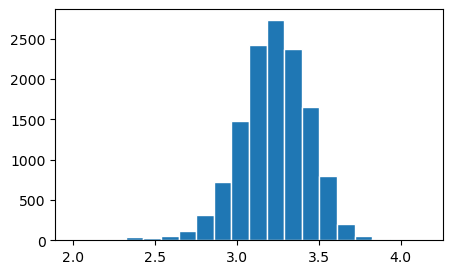

In [25]:
processed_Adzuna.loc[mask_frequent_job_titles].FullDescription.str.len().map(np.log10).hist(bins=20, ec='w', grid=False, figsize=(5, 3));

---
# Employers/Companies

Restrict the data to employers which appear at least four times.

In [26]:
frequent_companies = set(processed_Adzuna.Company.value_counts().pipe(lambda s: s[s>3]).index)
len(frequent_companies)

868

In [27]:
mask_frequent_companies = processed_Adzuna.Company.isin(frequent_companies)
mask_frequent_companies.sum()

18536

# Select data based on frequent jobs and companies

In [28]:
selection_Adzuna = processed_Adzuna.loc[np.logical_and(mask_frequent_job_titles, mask_frequent_companies)]

In [29]:
selection_Adzuna.shape

(11597, 10)

In [30]:
pattern_url_email = regex.compile("(http)|(www)|@", flags=regex.M)
pattern_non_words = regex.compile("[^A-z0-9&,/':\. ]")
pattern_stars = regex.compile("\*+")

def clean_text(comp):
    comp = pattern_url_email.sub('', comp)
    comp = pattern_stars.sub(' ', comp)
    comp = pattern_non_words.sub(' ', comp)
    comp = pattern_multiple_blanks.sub(' ', comp)
    return comp    

In [31]:
employers = sorted(
        set(selection_Adzuna.Company.swifter.apply(clean_text).dropna().values), 
    key=len, reverse=True)

employers = [e for e in employers 
             if (pattern_non_words.search(e) is None) and (pattern_url_email.search(e) is None)]
len(employers)

Pandas Apply:   0%|          | 0/11597 [00:00<?, ?it/s]

798

In [32]:
single_word_employer = {item for item in employers if len(item.split())==1}
ambiguous_employers = [item for item in single_word_employer if is_word(item.lower())
                       or ('.com' in item) 
                       or ('cv' in item.lower())
                      ]
print(sorted(ambiguous_employers))

['ARM', 'ATA', 'Abacus', 'Annapurna', 'Browns', 'CPL', 'CPS', 'Capita', 'Certes', 'Convert', 'EE', 'Empiric', 'Europa', 'Exclusive', 'Gold', 'Harvester', 'Hays', 'Hudson', 'Iceland', 'London', 'Metropolitan', 'PRS', 'Pavers', 'Prospectus', 'Real', 'Reed', 'STR', 'Salt', 'Spire', 'Stopgap', 'Synergy', 'Taskmaster', 'Tate', 'Three', 'Travail', 'Triad', 'UNICEF', 'Volt', 'WIS', 'Zurich', 'eNL', 'ecomrecruitment.com', 'hyphen']


In [33]:
employers = sorted(list(set(employers) - set(ambiguous_employers)), key=len, reverse=True)
len(employers)

755

In [34]:
employers[:5]

['LA International Computer Consultants Ltd',
 'Strata Construction Consulting UK Ltd',
 'Robinson Keane Finance Professionals',
 'Specialist Recruitment Partners LTD',
 'Trickett Ames Recruitment Solutions']

In [35]:
[e for e in employers if pattern_punctuation.search(e)]

['Randstad Financial & Professional',
 "Saint Michael's Hospice",
 'Sizzling Pub Co.',
 "O'Neill's"]

### Filter out employers that do not appear frequently enough

In [36]:
selection_Adzuna.Company.isin(employers).mean()

0.8978184013106838

In [37]:
selection_Adzuna = selection_Adzuna[selection_Adzuna.Company.isin(employers)]

In [38]:
selection_Adzuna.shape

(10412, 10)

### Take a closer look at the single word titles

In [39]:
selection_Adzuna[selection_Adzuna.Title.str.split().str.len()==1].Title.unique()

array(['Manager', 'Buyer', 'Electrician', 'Paralegal', 'Solicitor',
       'Inspector', 'Joiner', 'Chef', 'Housekeeper', 'Accountant',
       'Analyst', 'Driver', 'Administrator', 'Carpenter', 'Estimator',
       'Underwriter', 'Butcher', 'Cashier', 'Receptionist', 'Welder',
       'Optometrist', 'Merchandiser', 'Cook', 'Toolmaker', 'Bookkeeper',
       'Cleaner', 'Payroll', 'Secretary', 'Trainer', 'PA', 'Developer',
       'Designer', 'Technician', 'Scheduler', 'Plumber', 'Copywriter',
       'Labourer', 'Planner', 'Draughtsman', 'Supervisor', 'Auditor',
       'Machinist', 'Ombudsman', 'Wireman', 'Fitter', 'Caretaker',
       'Engineer', 'Sommelier', 'QP'], dtype=object)

In [40]:
selection_Adzuna[selection_Adzuna.Title=='QP']['FullDescription'].values

array(['QP  Salary Neg North England Leading Pharmaceutical Company Cubiq Recruitment is working with a leading pharmaceutical company and due to their rapid growth they are looking for an experienced QP to join their team. This is a great opportunity to further your experience in quality assurance and different dosage forms of products. Your role will be a strict QP position where your main duties will focus on batch review and release of the commercial products. You will also be involved with planning and implementing internal and external audits as well as maintaining the quality management system (QMS) This position gives you the perfect opportunity to further your career by expanding on your experience and will also give you the opportunity to join a company that is rapidly expanding not just in the UK but across the EU'],
      dtype=object)

Exclude a few more vague employer names.

In [41]:
exclusion = {
    'Year','TLO','QP','Brent','BA','PA','CORPORATE','FUNDS','Costs','IT',
    'Executive','Payroll','Financial','Reception','Domestic','Public Sector','Audit',
}

In [42]:
selection_Adzuna = selection_Adzuna[~selection_Adzuna.Title.isin(exclusion)]

In [43]:
selection_Adzuna[selection_Adzuna.Title.str.split().str.len()==1].Title.unique()

array(['Manager', 'Buyer', 'Electrician', 'Paralegal', 'Solicitor',
       'Inspector', 'Joiner', 'Chef', 'Housekeeper', 'Accountant',
       'Analyst', 'Driver', 'Administrator', 'Carpenter', 'Estimator',
       'Underwriter', 'Butcher', 'Cashier', 'Receptionist', 'Welder',
       'Optometrist', 'Merchandiser', 'Cook', 'Toolmaker', 'Bookkeeper',
       'Cleaner', 'Secretary', 'Trainer', 'Developer', 'Designer',
       'Technician', 'Scheduler', 'Plumber', 'Copywriter', 'Labourer',
       'Planner', 'Draughtsman', 'Supervisor', 'Auditor', 'Machinist',
       'Ombudsman', 'Wireman', 'Fitter', 'Caretaker', 'Engineer',
       'Sommelier'], dtype=object)

In [44]:
selection_Adzuna.shape

(10387, 10)

In [45]:
selection_Adzuna.sample(5, random_state=0)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
188671,72654414.0,Marketing Finance Controller,"Marketing Finance Controller, Oxford, Oxfordsh...","South East England, Oxfordshire",Oxfordshire,None,None,Vitae Financial Recruitment,Other/General Jobs,theladders.co.uk
205699,68359762.0,Agile Business Analyst,"Agile Business Analyst Agile, Prince**** SCRUM...",Leeds West Yorkshire Yorkshire,Leeds,None,permanent,TEKsystems,IT Jobs,cwjobs.co.uk
281449,72447862.0,Key Account Manager,Job Title: Key Account Manager Location: North...,North West,North West London,None,permanent,Cavendish Maine,Sales Jobs,totaljobs.com
105029,70438694.0,Mechanical Design Engineer,A skilled Mechanical Design Engineer position ...,"Sheffield, South Yorkshire",Sheffield,None,permanent,White Recruitment Ltd,Engineering Jobs,cv-library.co.uk
320209,72694209.0,Service Engineer,Field Service Engineer (ElectroMechanical) As ...,carlisle Newcastle Tyne and Wear England,UK,None,None,ATA Recruitment,Engineering Jobs,gojobsearch.co.uk


## Remove star symbols and multiple blanks from Full Description.

In [46]:
def clean_job_description(d):
    d = pattern_url_email.sub('', d)
    d = pattern_stars.sub(' ', d)
    d = pattern_multiple_blanks.sub(' ', d)
    return d    

In [47]:
%%time
selection_Adzuna['FullDescription'] = selection_Adzuna.FullDescription.swifter.apply(clean_job_description)

Pandas Apply:   0%|          | 0/10387 [00:00<?, ?it/s]

CPU times: user 1.3 s, sys: 15.6 ms, total: 1.31 s
Wall time: 1.31 s


In [48]:
selection_Adzuna.FullDescription.sample(2, random_state=0).values

array(['Marketing Finance Controller, Oxford, Oxfordshire kpa Plus Benefits Our Client, a world leading, multinational based at their impressive European Headquarters in Oxford are currently looking to source an ambitious, high calibre Marketing Finance Manager on a permanent basis. This is an exciting opportunity within a global organisation where numerical and analytical skills combined with strong interpersonal and business partnering skills are critical. The role requires someone who can influence and support the business to maximise value creation with insightful and actionable financial analysis for all significant marketing investment decisions. The role will include the following key areas: Work with the Marketing teams to ensure that business performance is clear and the drivers of performance are understood, including promotion trends, brand/ customer profitability and external competitor analysis. Develop financial analysis that challenges evaluates all marketing investment 

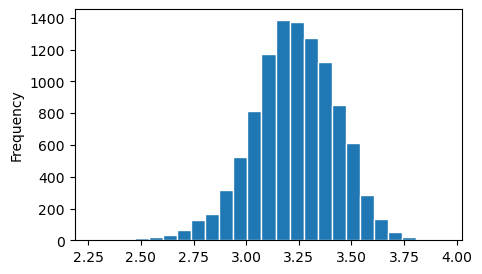

In [49]:
selection_Adzuna.FullDescription.str.len().map(np.log10).plot.hist(bins=25, ec='w', figsize=(5, 3));

In [50]:
mask_length = selection_Adzuna.FullDescription.str.len().map(np.log10).between(2.5, 3.5)
mask_length.sum()

9498

In [51]:
selection_Adzuna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10387 entries, 82 to 320258
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10387 non-null  float64
 1   Title               10387 non-null  object 
 2   FullDescription     10387 non-null  object 
 3   LocationRaw         10387 non-null  object 
 4   LocationNormalized  10387 non-null  object 
 5   ContractType        1996 non-null   object 
 6   ContractTime        8255 non-null   object 
 7   Company             10387 non-null  object 
 8   Category            10387 non-null  object 
 9   SourceName          10387 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.1+ MB


In [52]:
selection_Adzuna.Id = selection_Adzuna.Id.astype('int32')
assert not (selection_Adzuna.Id < 0).any()

In [53]:
selection_Adzuna.head(2)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
82,36757414,Primary Teachers,Are you a qualified/newly qualified teacher lo...,South Yorkshire,South Yorkshire,None,contract,Vision for Education,Teaching Jobs,cv-library.co.uk
121,44452524,Chef De Partie,Chef De Partie Rustic Italian AA Rosette resta...,Colchester Essex South East,UK,None,None,Clear Selection,Hospitality & Catering Jobs,caterer.com


## Save the cleaned data to disk

In [54]:
# hash the dataframe to uniquely identify different versions
def pd2hash(df):
    return hashlib.sha1(pd.util.hash_pandas_object(df).values).hexdigest() 

In [55]:
data_hash = pd2hash(selection_Adzuna) 
data_hash

'fba836ee1bdf4fda32004145ffe1eeb8d3c6b5f1'

In [56]:
path = Path(f'./experiments/data_{data_hash}')
try:
    path.mkdir(parents=True)
except FileExistsError:
    print(f'{path.name} already exists...')
    
filename = path/f'Adzuna_job_data_{data_hash}_docs.parq'
if not filename.exists():
    selection_Adzuna.to_parquet(filename)
    print('saved data file to parquet...')
else:
    print('File already exists...')

saved data file to parquet...


## Split text into sentences.

In [57]:
selection_Adzuna.head(2)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
82,36757414,Primary Teachers,Are you a qualified/newly qualified teacher lo...,South Yorkshire,South Yorkshire,None,contract,Vision for Education,Teaching Jobs,cv-library.co.uk
121,44452524,Chef De Partie,Chef De Partie Rustic Italian AA Rosette resta...,Colchester Essex South East,UK,None,None,Clear Selection,Hospitality & Catering Jobs,caterer.com


In [58]:
nlp = spacy.load('en_core_web_sm', enable=['senter'], disable=[])

In [59]:
def get_sentences(row, nlp=None):
    text = row['FullDescription']
    doc_id = row['Id']
    doc = nlp(text)
    df = pd.DataFrame([(doc_id, i, s.text.strip()) for i, s in enumerate(doc.sents) if pattern_punctuation.sub('', s.text).strip()], 
                      columns=['doc_id', 'sent_id', 'sentence'])
    return df

In [60]:
t = selection_Adzuna.FullDescription.iloc[0]
t

'Are you a qualified/newly qualified teacher looking for supply work in and around South Yorkshire? Do you want a new challenge with varied work, flexibility and great rates of pay? If so, Vision for Education can help We are currently looking for enthusiastic and dedicated KS and KS Primary Teachers for a number of schools across the area. Candidates must have an enthusiasm for teaching, a good knowledge of the national curriculum and excellent classroom and behaviour management skills. It is essential that you hold a valid, recognised teaching qualification and ideally you will have 6 weeks recent experience of teaching in the UK. We must also be able to contact your past school to obtain a reference. Vision for Education was started in by a group of like minded individuals with a desire for providing a quality service to customers. Our promise is to serve the education community, be it Teachers, Schools or Students alike to the highest possible standards. If you are looking for a pr

In [61]:
%%time
tmp = selection_Adzuna.swifter.apply(get_sentences, nlp=nlp, axis=1)

Pandas Apply:   0%|          | 0/10387 [00:00<?, ?it/s]

CPU times: user 24.5 s, sys: 508 ms, total: 25 s
Wall time: 25.1 s


In [62]:
%%time
selection_Adzuna_sentences = pd.concat(tmp.values, ignore_index=True)

CPU times: user 526 ms, sys: 6.32 ms, total: 532 ms
Wall time: 532 ms


In [63]:
selection_Adzuna_sentences = selection_Adzuna_sentences.assign(sent_len = lambda _: _.sentence.str.len())

In [64]:
selection_Adzuna_sentences.head(2)

,doc_id,sent_id,sentence,sent_len
0,36757414,0,Are you a qualified/newly qualified teacher lo...,98
1,36757414,1,"Do you want a new challenge with varied work, ...",81


In [65]:
filename = path/f'Adzuna_job_data_{data_hash}_sents.parq'
if not filename.exists():
    selection_Adzuna_sentences.to_parquet(filename)
    print('saved data file to parquet...')
else:
    print('File already exists...')

saved data file to parquet...


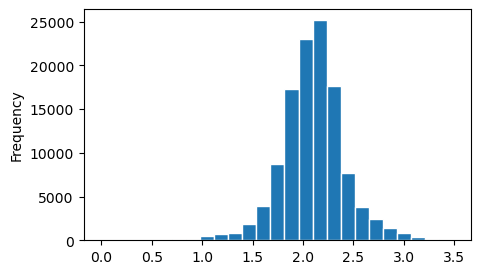

In [66]:
selection_Adzuna_sentences.sent_len.map(np.log10).plot.hist(bins=25, ec='w', figsize=(5, 3));